## Feed-forward NN Regressor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df_bikesharing = pd.read_excel('Bike_Sharing_day.xlsx', sheetname="day")
dummy=df_bikesharing
dummy.head()

/Users/fernandojavier/anaconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [3]:
df_features=dummy.drop('count', axis=1)
df_features=df_features.drop('instant', axis=1)
df_features=df_features.drop('dteday', axis=1)
len(df_features)
df_features.head(5)

X = df_features
y = dummy['count']



##Run this if you want to scale the input and output 

'''yy=np.reshape(y, (-1,1))

from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
X = sscaler.fit_transform(X)
y = sscaler.fit_transform(yy)'''




'yy=np.reshape(y, (-1,1))\n\nfrom sklearn.preprocessing import MinMaxScaler\nsscaler = MinMaxScaler()\nX = sscaler.fit_transform(X)\ny = sscaler.fit_transform(yy)'

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [5]:
X_train.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
521,2,1,6,0,2,1,2,0.540833,0.525892,0.613333,0.209575
147,2,0,5,0,6,0,1,0.655833,0.612379,0.729583,0.230092
472,2,1,4,0,2,1,1,0.608333,0.598487,0.390417,0.273629
635,4,1,9,0,4,1,2,0.650000,0.607975,0.690833,0.134342
331,4,0,11,0,1,1,1,0.503478,0.490122,0.743043,0.142122


In [6]:
y_train = y_train/10000
y_test = y_test/10000

In [14]:
from sklearn.metrics import r2_score

# RANDOM SEED
np.random.seed(42)


def mape(y_pred, y_true):
    return float(np.mean(np.abs((y_pred - y_true)/y_true)))


def rmse(y_pred, y_true):
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))


class NN():
    # get attributes and initiate weights
    def __init__(self,
                 X_train, y_train,
                 X_test, y_test,
                 kind,
                 num_hidden_layers,
                 nodes=[],
                 learning_rate=(0.1, 0.1),
                 activation=('linear', 'sigmoid', 'sigmoid')):

        self.input = X_train
        self.output = y_train
        self.X_test0 = X_test  # FOR TESTING PURPOSES DURING TRAINING
        self.y_test0 = y_test  # FOR TESTING PURPOSES DURING TRAINING
        self.kind = kind

        self.num_hidden_layers = num_hidden_layers
        self.nodes = nodes
        self.lr = learning_rate
        self.activation = activation

        # UPDATE THIS
        # initiate weights
        self.weights = []
        self.best_weights = []
        for i in range(self.num_hidden_layers + 1):
            self.weights.append(
                2 * np.random.random((self.nodes[i], self.nodes[i + 1])) - 1)
            self.best_weights.append(self.weights[i])

        # SCORES AND ERRORS
        self.train_errors = []
        self.train_r2 = []
        self.test_r2 = []
        self.train_mape = []
        self.test_mape = []
        self.train_rmse = []
        self.test_rmse = []

    # functions

    def f(self, x, func_name, deriv=False):
        if func_name == 'sin':
            if(deriv == True):
                return np.cos(x)
            return np.sin(x)
        elif func_name == 'tanh':
            if(deriv == True):
                return 1.7159 * (1 - (np.tanh(2 * x / 3)**2)**2) / 3
            return 1.7159 * np.tanh(2 * x / 3)
        elif func_name == 'linear':
            if(deriv == True):
                return 1
            return x
        elif func_name == 'sigmoid':
            sig = 1 / (1 + np.exp(-x))
            if(deriv == True):
                return sig * (1 - sig)
            return sig
        elif func_name == 'relu':
            if(deriv == True):
                b = x >= 0
                return b.astype(int)
            return x.clip(min=0)

    def feed_forward(self, num_iter):

        for iters in range(num_iter):

            # initialize
            unactivated = []
            activated = []
            unactivated_test = []
            activated_test = []
            deltas = []

            # feed forward
            # 0 layer 0 activated
            activated.append(self.f(self.input, self.activation[0]))

            for i in range(self.num_hidden_layers + 1):
                unactivated.append(
                    np.dot(activated[i], self.weights[i]))
                activated.append(
                    self.f(unactivated[i], func_name=self.activation[i + 1]))

            y_out_nn = activated[-1][:]

            # Error Function
            error = self.output - y_out_nn
            self.train_errors.append(np.mean(np.abs(error)))

            # Test Accuracy
            # 0 layer0 activated
            activated_test.append(self.f(self.X_test0, self.activation[0]))

            for i in range(self.num_hidden_layers + 1):
                unactivated_test.append(
                    np.dot(activated_test[i], self.weights[i]))
                activated_test.append(self.f(
                    unactivated_test[i], func_name=self.activation[i + 1]))

            y_out_test = activated_test[-1][:]

            # TRAIN AND TEST ACCURACIES
            if self.kind == 'regressor':

                train_rmse = rmse(y_out_nn, self.output)
                train_r2 = r2_score(self.output, y_out_nn)
                train_mape = mape(y_out_nn, self.output)

                self.train_r2.append(train_r2)
                self.train_mape.append(train_mape)
                self.train_rmse.append(train_rmse)

                test_mape = mape(y_out_test, self.y_test0)
                test_rmse = rmse(y_out_test, self.y_test0)
                test_r2 = r2_score(self.y_test0, y_out_test)

                self.test_r2.append(test_r2)
                self.test_rmse.append(test_rmse)
                self.test_mape.append(test_mape)

            elif self.kind == 'classifier':
                y_out_nn = np.rint(y_out_nn)  # convert to integers
                train_acc = accuracy_score(y_out_nn, self.output)
                y_out_test = np.rint(y_out_test)
                test_acc = accuracy_score(y_out_test, self.y_test0)

                self.train_accs.append(train_acc)
                self.test_accs.append(test_acc)

            # APPENDING BEST WEIGHTS
            if iters > 4 and test_r2 > max(self.test_r2[:-1]):
                for i in range(self.num_hidden_layers + 1):
                    self.best_weights[i] = self.weights[i]

            # print iteration results
            if (iters % int(num_iter / 10)) == 0:
                print("i:", iters,
                      "error:", np.round(np.mean(np.abs(error)), 2),
                      "train r2:", np.round(train_r2, 2),
                      "valid r2:", np.round(test_r2, 2),
                      "train MAPE:", np.round(train_mape, 2),
                      "valid MAPE:", np.round(test_mape, 2))
#                       "train RMSE:", np.round(train_rmse, 2),
#                       "valid RMSE:", np.round(test_rmse, 2))

            # gradient updates
            deltas.append(error * self.f(unactivated[self.num_hidden_layers],
                                         func_name=self.activation[self.num_hidden_layers + 1], deriv=True))

            for i in range(self.num_hidden_layers):
                deltas.append(deltas[i].dot(self.weights[self.num_hidden_layers - i].T) *
                              self.f(unactivated[self.num_hidden_layers - 1 - i], func_name=self.activation[self.num_hidden_layers - i], deriv=True))

            # update weights
            self.weights[self.num_hidden_layers] += self.lr[self.num_hidden_layers] * \
                activated[self.num_hidden_layers].T.dot(deltas[0])
            for i in range(1, self.num_hidden_layers):
                self.weights[i] += self.lr[i] * \
                    unactivated[self.num_hidden_layers -
                                1 - i].T.dot(deltas[i])
            self.weights[0] += self.lr[0] * \
                activated[0].T.dot(deltas[self.num_hidden_layers])

        print("done training")

    # Predict X_test, output y_predicted
    def predict(self, X_test):
        "Predict values using best weights"

        unactivated = []
        activated = []

        # 0 layer0 activated
        activated.append(self.f(X_test, self.activation[0]))
        for i in range(self.num_hidden_layers + 1):
            unactivated.append(
                np.dot(activated[i], self.best_weights[i]))
            activated.append(
                self.f(unactivated[i], func_name=self.activation[i + 1]))

        y_out_test = activated[-1][:]
        return y_out_test

In [24]:
X_train2 = X_train.iloc[:, ]
y_train2 = y_train.iloc[:].values.reshape(-1, 1)
y_test2 = y_test.iloc[:].values.reshape(-1, 1)
nodes = [11, 14, 14, 1]


NN_ = NN(
    X_train2, y_train2,
    X_test, y_test2,
    'regressor',
    num_hidden_layers=2,
    nodes=nodes,
    learning_rate=(0.01, 0.001, 0.001),
    activation=('linear', 'sin', 'sigmoid', 'sigmoid'))

In [25]:
NN_.feed_forward(5000)

i: 0 error: 0.28 train r2: -1.99 valid r2: -1.32 train MAPE: 0.73 valid MAPE: 0.56
i: 500 error: 0.07 train r2: 0.78 valid r2: 0.77 train MAPE: 0.48 valid MAPE: 0.26
i: 1000 error: 0.06 train r2: 0.83 valid r2: 0.8 train MAPE: 0.41 valid MAPE: 0.22
i: 1500 error: 0.06 train r2: 0.86 valid r2: 0.81 train MAPE: 0.4 valid MAPE: 0.2
i: 2000 error: 0.05 train r2: 0.87 valid r2: 0.81 train MAPE: 0.38 valid MAPE: 0.2
i: 2500 error: 0.05 train r2: 0.88 valid r2: 0.81 train MAPE: 0.34 valid MAPE: 0.19
i: 3000 error: 0.05 train r2: 0.88 valid r2: 0.81 train MAPE: 0.32 valid MAPE: 0.19
i: 3500 error: 0.05 train r2: 0.89 valid r2: 0.81 train MAPE: 0.3 valid MAPE: 0.19
i: 4000 error: 0.05 train r2: 0.89 valid r2: 0.81 train MAPE: 0.29 valid MAPE: 0.19
i: 4500 error: 0.05 train r2: 0.89 valid r2: 0.8 train MAPE: 0.29 valid MAPE: 0.19
done training


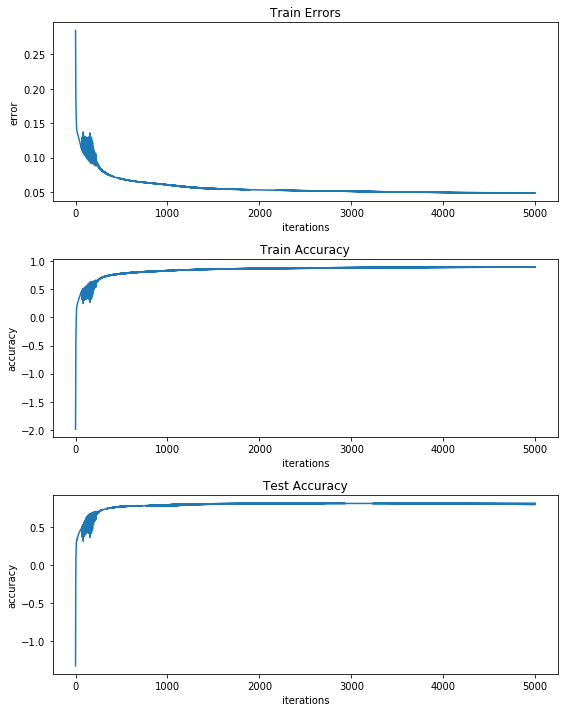

In [27]:
# import matplotlib.pyplot as plt
f, ax = plt.subplots(3, 1, figsize=(8,10))
ax[0].plot(NN_.train_errors)
ax[0].set_title('Train Errors')
ax[0].set_xlabel('iterations')
ax[0].set_ylabel('error')

ax[1].plot(NN_.train_r2)
ax[1].set_title('Train Accuracy')
ax[1].set_xlabel('iterations')
ax[1].set_ylabel('accuracy')
                 
ax[2].plot(NN_.test_r2)
ax[2].set_title('Test Accuracy')
ax[2].set_xlabel('iterations')
ax[2].set_ylabel('accuracy')

plt.tight_layout()

In [29]:
# MAX TEST ACCURACY
print(np.argmax(NN_.test_r2))
print(max(NN_.test_r2))


2350
0.8149171020631896


In [30]:
r2_score(NN_.predict(X_test), y_test)

0.7832144127214528

## Feed-forward NN Classifier

In [15]:
df_UPCAT = pd.read_excel('UPCAT_DATA2.xlsx', sheetname='AllData')
dummy = df_UPCAT
dummy.head()

/Users/fernandojavier/anaconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,Batch,Eng7,Eng8,Eng9,Math7,Math8,Math9,Sci7,Sci8,Sci9,GWA7,GWA8,GWA9,UP,IQ,SA,C1,C2,Target
0,2005,77,82.0,86,94,87,92.0,84,80,92,1.4764,1.5045,1.4098,1,55.0,28,1,4.0,1
1,2005,57,57.0,59,55,46,57.0,53,45,53,2.6557,2.7000,2.7008,1,38.0,19,5,3.0,0
2,2005,55,52.0,55,57,53,51.0,57,62,51,2.6132,2.6818,2.7172,0,17.0,9,5,6.0,0
3,2005,69,78.0,78,87,79,79.0,83,82,79,1.7217,1.6136,1.7049,1,45.0,28,1,4.0,0
4,2005,64,71.0,68,71,57,54.0,60,59,55,2.4245,2.4318,2.4713,1,67.0,56,1,5.0,0


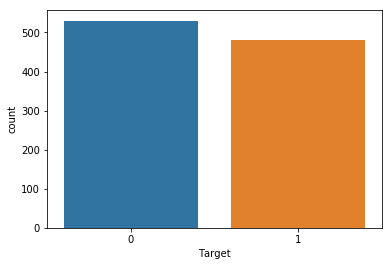

In [16]:
import seaborn as sns
sns.countplot(df_UPCAT['Target'],label="Count")
plt.show()

In [17]:
dummy.columns

Index(['Batch', 'Eng7', 'Eng8', 'Eng9', 'Math7', 'Math8', 'Math9', 'Sci7',
       'Sci8', 'Sci9', 'GWA7', 'GWA8', 'GWA9', 'UP', 'IQ', 'SA', 'C1', 'C2',
       'Target'],
      dtype='object')

In [18]:
feature_names = ['Eng7', 'Eng8', 'Eng9', 'Math7', 'Math8', 'Math9', 'Sci7',
       'Sci8', 'Sci9', 'GWA7', 'GWA8', 'GWA9', 'UP', 'IQ', 'SA', 'C1', 'C2']

X = df_UPCAT[feature_names]
y = df_UPCAT['Target']


In [19]:
y.shape

(1010,)

In [20]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)



X_transition = pd.DataFrame(X)
X_clean = DataFrameImputer().fit_transform(X_transition)

X_clean.isnull().sum()

Eng7     0
Eng8     0
Eng9     0
Math7    0
Math8    0
Math9    0
Sci7     0
Sci8     0
Sci9     0
GWA7     0
GWA8     0
GWA9     0
UP       0
IQ       0
SA       0
C1       0
C2       0
dtype: int64

In [21]:
X_clean.shape

(1010, 17)

In [22]:
from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
X = sscaler.fit_transform(X_clean)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.25, random_state=42)

In [24]:
y0=np.array(y_train, ndmin=2).T
y0[:5]

array([[1],
       [1],
       [0],
       [0],
       [1]])

In [25]:
y_test0=np.array(y_test, ndmin=2).T

In [28]:
X_train2 = X_train.values[:]
y_train2 = y0[:]

nodes = [17, 17, 1]

y_test = y_test0[:]


NN_ = NN(
        'classifier',
        X_train2, y_train2,
         X_test, y_test,
        num_hidden_layers=1,
         nodes=nodes,
         learning_rate=(0.001, 0.0001),
         activation=('linear', 'sigmoid', 'sigmoid'))

In [29]:
NN_.feed_forward(7976)

/Users/fernandojavier/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: overflow encountered in exp


Iteration: 0 Abs Error= 0.4863824954276919 Test Acc= 0.5335968379446641
Iteration: 797 Abs Error= 0.4002442961658314 Test Acc= 0.7154150197628458
Iteration: 1594 Abs Error= 0.38755766259090213 Test Acc= 0.7075098814229249
Iteration: 2391 Abs Error= 0.38356809356447696 Test Acc= 0.6877470355731226
Iteration: 3188 Abs Error= 0.36006812634277846 Test Acc= 0.7154150197628458
Iteration: 3985 Abs Error= 0.3467591901743794 Test Acc= 0.7509881422924901
Iteration: 4782 Abs Error= 0.3844058192510323 Test Acc= 0.691699604743083
Iteration: 5579 Abs Error= 0.36529414493525825 Test Acc= 0.7154150197628458
Iteration: 6376 Abs Error= 0.3356023940095169 Test Acc= 0.7549407114624506
Iteration: 7173 Abs Error= 0.33786045561731326 Test Acc= 0.7509881422924901
Iteration: 7970 Abs Error= 0.3357816422617224 Test Acc= 0.7509881422924901
done training


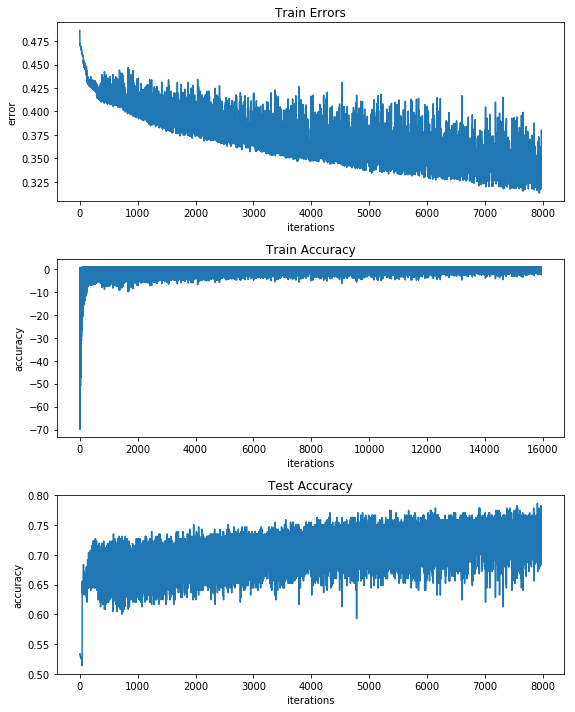

In [30]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(3, 1, figsize=(8,10))
ax[0].plot(NN_.train_errors)
ax[0].set_title('Train Errors')
ax[0].set_xlabel('iterations')
ax[0].set_ylabel('error')

ax[1].plot(NN_.train_accs)
ax[1].set_title('Train Accuracy')
ax[1].set_xlabel('iterations')
ax[1].set_ylabel('accuracy')
                 
ax[2].plot(NN_.test_accs)
ax[2].set_title('Test Accuracy')
ax[2].set_xlabel('iterations')
ax[2].set_ylabel('accuracy')

plt.tight_layout()

In [31]:
# MAX TEST ACCURACY
print(np.argmax(NN_.test_accs))
print(max(NN_.test_accs))


7908
0.7865612648221344


In [32]:
y_pred = np.rint(NN_.predict(X_test))
accuracy_score(y_pred, y_test0)

0.7984189723320159


Confusion Matrix Using Best Parameters


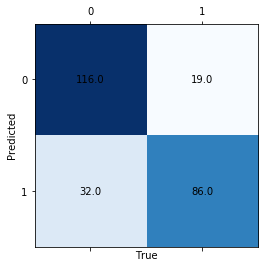

In [33]:
# Confusion Matrix
print()
print("Confusion Matrix Using Best Parameters")
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()